In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
######## 读取数据 ########
sheet = pd.read_excel('data_input/中石化航空煤油企业结算价.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
last_day = sheet['中石化航空煤油企业结算价Trend/F0.2'].last_valid_index()

sheet.columns  

Index(['中石化航空煤油企业结算价', '中石化航空煤油企业结算价Trend/F0.2', 'WTI连1合约价格（路透）Trend/F=0.2'], dtype='object')

In [4]:
sheet = sheet.resample('ME').mean()
sheet.tail()

,中石化航空煤油企业结算价,中石化航空煤油企业结算价Trend/F0.2,WTI连1合约价格（路透）Trend/F=0.2
Date,,,
2025-07-31,NaN,NaN,63.735039
2025-08-31,NaN,NaN,62.770458
2025-09-30,NaN,NaN,61.828515
2025-10-31,NaN,NaN,60.843720
2025-11-30,NaN,NaN,60.231362


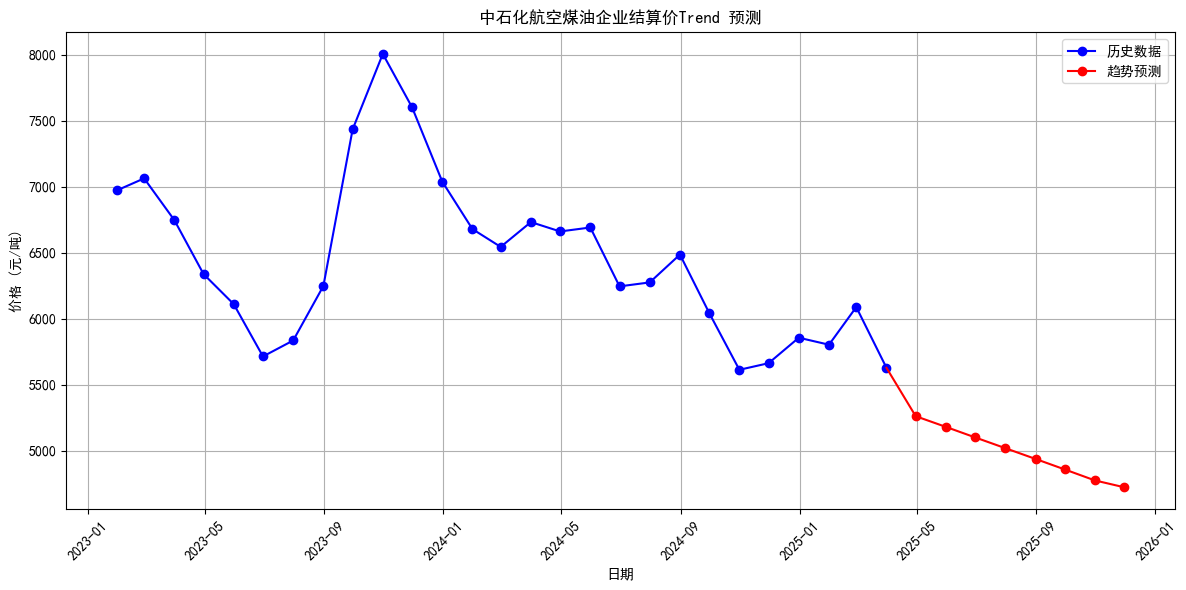

In [5]:
# 准备训练数据
sheet = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily = sheet.copy()
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy().dropna()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

# 准备训练数据
X_train = train_data['WTI连1合约价格（路透）Trend/F=0.2'].values.reshape(-1, 1)
y_train = train_data['中石化航空煤油企业结算价Trend/F0.2'].values

# 训练模型
model = LinearRegression()
model.fit(X_train, y_train)

# 获取最后一个有效日期之后的预测数据
future_X = future_data['WTI连1合约价格（路透）Trend/F=0.2'].values.reshape(-1, 1)
future_predictions = model.predict(future_X)

future_df = pd.DataFrame({
    'Date': future_data['Date'],
    '中石化航空煤油企业结算价Trend/F0.2': future_predictions
})

# 绘制图表展示
train_data_2023 = train_data[train_data['Date'] >= '2023-01-01']
plt.figure(figsize=(12, 6))
# 绘制历史数据,选取2023年1月以后的数据
plt.plot(train_data_2023['Date'], train_data_2023['中石化航空煤油企业结算价'], 'b-', label='历史数据', marker='o')
# 连接历史数据最后一个点和预测数据第一个点
plt.plot([train_data['Date'].iloc[-1], future_df['Date'].iloc[0]], 
         [train_data['中石化航空煤油企业结算价'].iloc[-1], future_df['中石化航空煤油企业结算价Trend/F0.2'].iloc[0]], 'r-')
# 绘制预测数据
plt.plot(future_df['Date'], future_df['中石化航空煤油企业结算价Trend/F0.2'], 'r-', label='趋势预测', marker='o')

plt.title('中石化航空煤油企业结算价Trend 预测')
plt.xlabel('日期')
plt.ylabel('价格 (元/吨)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

In [6]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/中石化航空煤油企业结算价Non-Trend—F0.2_合并数据.xlsx', sheet_name='Sheet1')
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])
# trend + non-trend 
merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    future_df[['Date', '中石化航空煤油企业结算价Trend/F0.2']], 
    on='Date',
    how='outer'
)
# 删除包含空值的行
merged_df = merged_df.dropna()
# 计算最终的
merged_df['中石化航空煤油企业结算价'] = merged_df['预测值'] + merged_df['中石化航空煤油企业结算价Trend/F0.2']
merged_df.tail() 

,Date,预测值,中石化航空煤油企业结算价Trend/F0.2,中石化航空煤油企业结算价
27,2025-04-30,-5.2313,5260.401349,5255.170049
28,2025-05-31,-44.5763,5179.292316,5134.716016


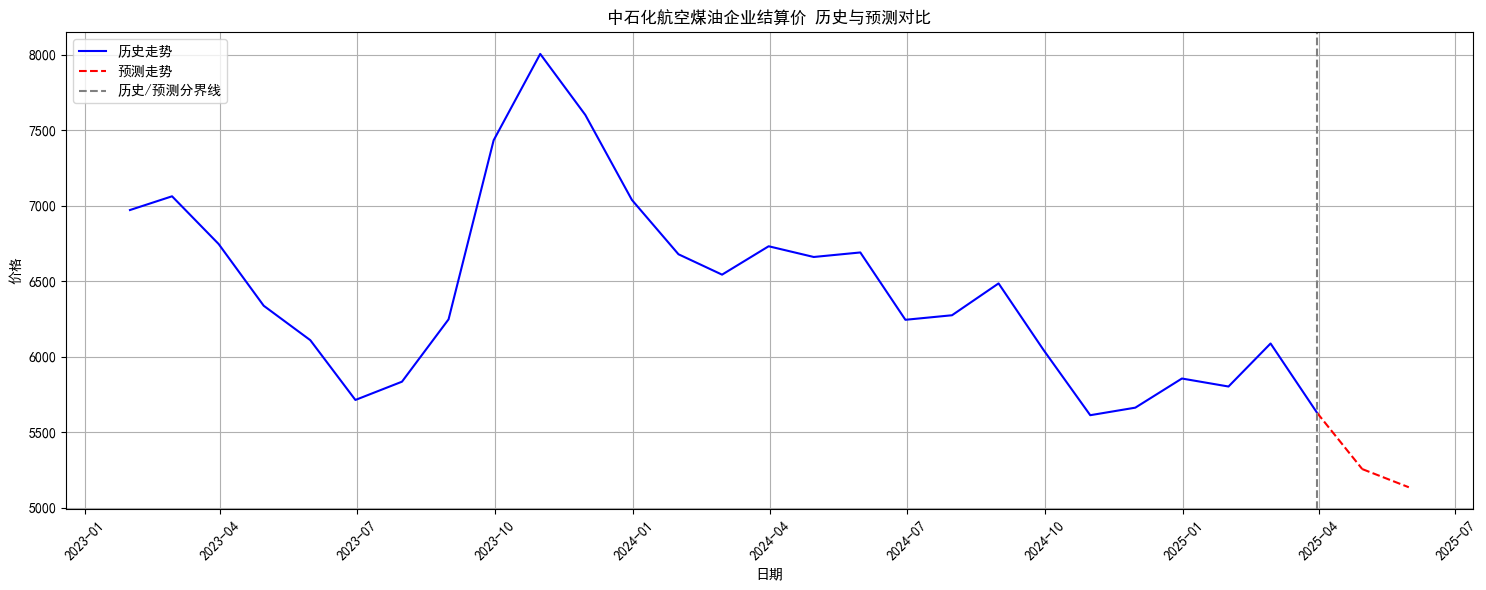

In [7]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2023-01-01']
plt.plot(sheet_2020['Date'], sheet_2020['中石化航空煤油企业结算价'], label='历史走势', color='blue')

# 连接历史数据最后一个点和预测数据第一个点
plt.plot([last_day, merged_df['Date'].iloc[0]], [sheet_2020[sheet_2020['Date'] == last_day]['中石化航空煤油企业结算价'].iloc[0], merged_df['中石化航空煤油企业结算价'].iloc[0]], 'r--')

plt.plot(merged_df['Date'], merged_df['中石化航空煤油企业结算价'], label='预测走势', color='red', linestyle='--')
plt.axvline(x=last_day, color='gray', linestyle='--', label='历史/预测分界线')
plt.title('中石化航空煤油企业结算价 历史与预测对比')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '中石化航空煤油企业结算价']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '中石化航空煤油企业结算价']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/中石化航空煤油企业结算价_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_shizhi.head()

,Date,实际值,中石化航空煤油企业结算价
34,2025/11/30,NaN,NaN
33,2025/10/31,NaN,NaN
32,2025/09/30,NaN,NaN
31,2025/08/31,NaN,NaN
30,2025/07/31,NaN,NaN


In [9]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_shizhi.to_excel('eta/中石化航空煤油企业结算价_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head()

,Date,实际值,中石化航空煤油企业结算价
0,2025/11/30,NaN,NaN
1,2025/10/31,NaN,NaN
2,2025/09/30,NaN,NaN
3,2025/08/31,NaN,NaN
4,2025/07/31,NaN,NaN


---

In [10]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '中石化航空煤油企业结算价Trend/F0.2']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/中石化航空煤油企业结算价Trend-F0.2_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_trend.head()

,Date,实际值,中石化航空煤油企业结算价Trend/F0.2
34,2025/11/30,NaN,4721.999969
33,2025/10/31,NaN,4773.766742
32,2025/09/30,NaN,4857.018121
31,2025/08/31,NaN,4936.646944
30,2025/07/31,NaN,5018.189522


In [11]:
# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_trend.to_excel('eta/中石化航空煤油企业结算价Trend-F0.2_月度数据.xlsx', index=False, float_format='%.4f')
monthly_df_trend.head()

,Date,实际值,中石化航空煤油企业结算价Trend/F0.2
0,2025/11/30,NaN,4721.999969
1,2025/10/31,NaN,4773.766742
2,2025/09/30,NaN,4857.018121
3,2025/08/31,NaN,4936.646944
4,2025/07/31,NaN,5018.189522


---

In [12]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中石化航空煤油企业结算价Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [13]:
'''
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中石化航空煤油企业结算价Trend/F0.2"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Lcel import update_excel_data\nfile_path = "eta/1.汽柴煤油_数据上传.xlsx"\nsheet_name = "详情页"\nidentifier = "中石化航空煤油企业结算价Trend/F0.2"       # NEW: 新增日期标识符列的抬头\n# 调用函数更新数据\nsuccess = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中石化航空煤油企业结算价"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
'''
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中石化航空煤油企业结算价"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Lcel import update_excel_data\nfile_path = "eta/1.汽柴煤油_数据上传.xlsx"\nsheet_name = "详情页"\nidentifier = "中石化航空煤油企业结算价"       # NEW: 新增日期标识符列的抬头\n# 调用函数更新数据\nsuccess = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'